# Tutorial #3.1: Off-road Navigaiton with CL-RRT

This tutorial runs closed-loop RRT (CL-RRT) with probabilistic traversability model. Some studies exploit such a sampling-based global planning algorithm to tightly couple robot dynamics with planning. We implement them to compare its performance against other planning algorithms.

In [1]:
%matplotlib inline
# Import the necessary libraries

# Add the parent directory to the path so that the environment can be found
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

# Import the necessary libraries
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Import the necessary classes
from src.environments.grid_map import GridMap
from src.simulator.planetary_env import PlanetaryEnv
from src.simulator.problem_formulation.utils import ModelConfig
from src.simulator.problem_formulation.robot_model import UnicycleModel
from src.simulator.problem_formulation.objectives import Objectives
from src.planners.global_planners.sampling_based.cl_rrt import CLRRT
from src.prediction_models.trainers.utils import ParamsModelTraining
from src.prediction_models.trainers.utils import load_model_state_dict
from src.prediction_models.trainers.utils import load_slip_regressors
from src.prediction_models.terrain_classifiers.unet import Unet
from src.prediction_models.slip_regressors.gpr import GPModel
from src.prediction_models.traversability_predictors.classifier_and_regressor import (
    TraversabilityPredictor,
)

sns.set()

device = "cuda" if torch.cuda.is_available() else "cpu"

1. Prepare ML models representing probabilistic traversability by loading both terrain classifier and slip regressors.

In [2]:
dataset_index = 1
num_total_terrain_classes = 10

# Set the path to model directory
base_directory = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
model_directory = os.path.join(
    base_directory, f"trained_models/dataset{dataset_index:02d}"
)

# Set the model configuration to load the terrain classifier
params_model_training = ParamsModelTraining(
    batch_size=16,
    learning_rate=1e-3,
    weight_decay=0e00,
    num_epochs=100,
    save_interval=None,
    device=device,
)
model_directory_unet = os.path.join(
    model_directory,
    "Unet",
    f"bs{params_model_training.batch_size:03d}_"
    f"lr{params_model_training.learning_rate:.0e}_"
    f"wd{params_model_training.weight_decay:.0e}_"
    f"epochs{params_model_training.num_epochs:03d}",
    "models/best_model.pth",
)

# Load the terrain classifier
terrain_classifier = Unet(classes=num_total_terrain_classes).to(device)

# Load the trained model
terrain_classifier = load_model_state_dict(
    terrain_classifier, model_directory_unet, device
)

# Set the model configuration to load the slip regressor
params_model_training = ParamsModelTraining(
    learning_rate=1e-1, num_iterations=100, device=device
)

model_directory_gpr = os.path.join(
    model_directory,
    "GPR",
    f"lr{params_model_training.learning_rate:.0e}_"
    f"iters{params_model_training.num_iterations:03d}",
)

# Load the slip regressor
all_gp_models = load_slip_regressors(
    model=GPModel,
    num_terrain_classes=num_total_terrain_classes,
    model_directory=model_directory_gpr,
    train_data_directory=os.path.join(
        base_directory, f"datasets/dataset{dataset_index:02d}/"
    ),
    device=device,
)

# Integrate the terrain classifier and the slip regressor into the traversability predictor
traversability_predictor = TraversabilityPredictor(
    terrain_classifier=terrain_classifier,
    slip_regressors=all_gp_models,
    device=device,
)

2. Prepare data for traversability prediction and motion planning problems.

In [3]:
subset_index = 1
instance_name = "000_000"
data_directory = os.path.join(
    base_directory,
    f"datasets/dataset{dataset_index:02d}/test/subset{subset_index:02d}/{instance_name}.pt",
)

# Load the data
data_item = torch.load(data_directory)
tensors = data_item["tensors"]
distributions = data_item["distributions"]

3. Predict traversability by providing color and slope information into the predictor.

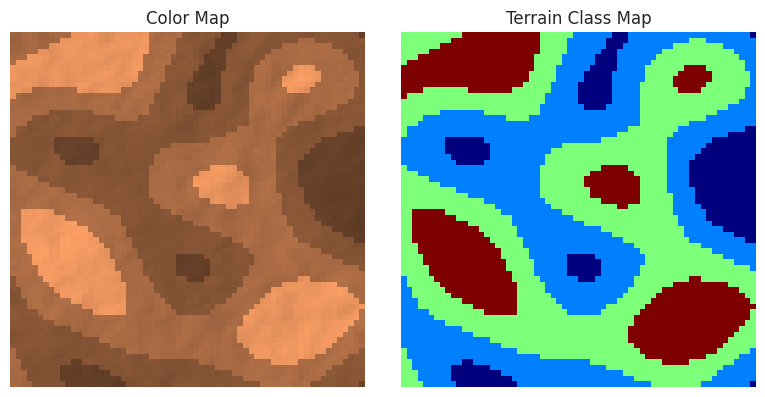

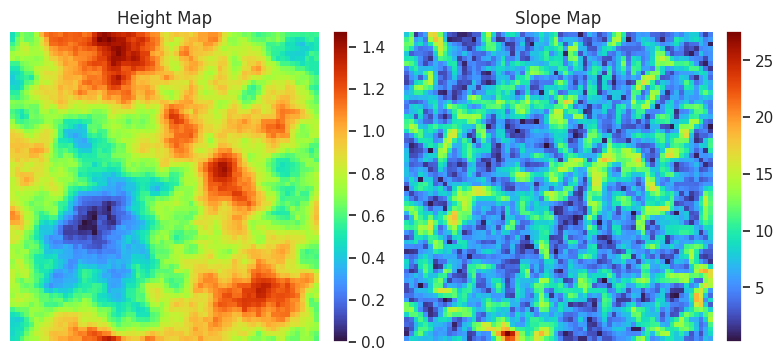

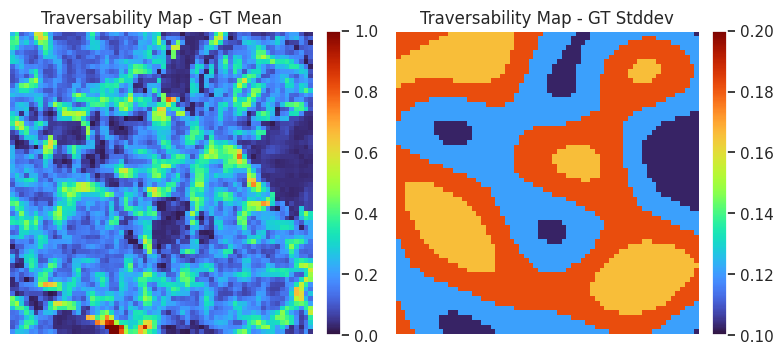

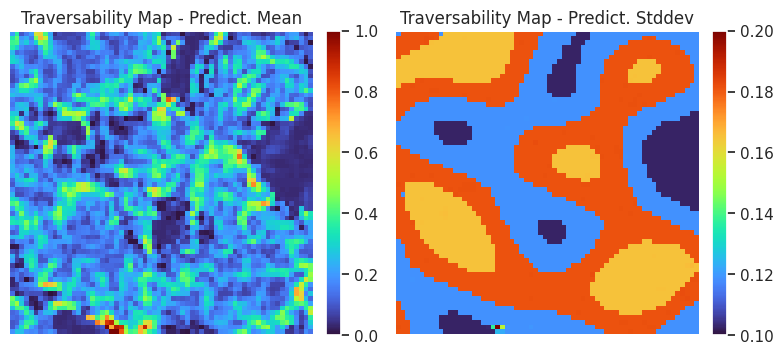

In [4]:
predictions = traversability_predictor.predict(
    colors=tensors["colors"], slopes=tensors["slopes"]
)
distributions["predictions"] = predictions

# Torch -> NumPy conversion
slips_mean = distributions["latent_models"].mean.cpu().numpy()
slips_stddev = distributions["latent_models"].stddev.cpu().numpy()
pred_mean = distributions["predictions"].mean.cpu().numpy()
pred_stddev = distributions["predictions"].stddev.cpu().numpy()

# Visualize the input color and slope images
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(tensors["colors"].permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Color Map")
axs[0].axis("off")
axs[0].set_aspect("equal")

axs[1].imshow(tensors["t_classes"].cpu().numpy(), cmap="jet")
axs[1].set_title("Terrain Class Map")
axs[1].axis("off")
axs[1].set_aspect("equal")
plt.tight_layout()


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

img = axs[0].imshow(tensors["heights"].cpu().numpy(), cmap="turbo")
axs[0].set_title("Height Map")
axs[0].axis("off")
axs[0].set_aspect("equal")
fig.colorbar(img, ax=axs[0], orientation="vertical", fraction=0.046, pad=0.04)

img = axs[1].imshow(tensors["slopes"].cpu().numpy(), cmap="turbo")
axs[1].set_title("Slope Map")
axs[1].axis("off")
axs[1].set_aspect("equal")
fig.colorbar(img, ax=axs[1], orientation="vertical", fraction=0.046, pad=0.04)
plt.tight_layout()


# Visualize the traversability predictions
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# mean map
mean_img = axs[0].imshow(slips_mean, cmap="turbo", vmin=0, vmax=1)
axs[0].set_title("Traversability Map - GT Mean")
axs[0].axis("off")
fig.colorbar(mean_img, ax=axs[0], orientation="vertical", fraction=0.046, pad=0.04)

# stddev map
stddev_img = axs[1].imshow(slips_stddev, cmap="turbo", vmin=0.1, vmax=0.2)
axs[1].set_title("Traversability Map - GT Stddev")
axs[1].axis("off")
fig.colorbar(stddev_img, ax=axs[1], orientation="vertical", fraction=0.046, pad=0.04)
plt.tight_layout()


fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# mean map
mean_img = axs[0].imshow(pred_mean, cmap="turbo", vmin=0, vmax=1)
axs[0].set_title("Traversability Map - Predict. Mean")
axs[0].axis("off")
fig.colorbar(mean_img, ax=axs[0], orientation="vertical", fraction=0.046, pad=0.04)

# stddev map
stddev_img = axs[1].imshow(pred_stddev, cmap="turbo", vmin=0.1, vmax=0.2)
axs[1].set_title("Traversability Map - Predict. Stddev")
axs[1].axis("off")
fig.colorbar(stddev_img, ax=axs[1], orientation="vertical", fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()